# Satellite imagery tile generation

## Imports and setup

In [ ]:
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
import rasterio
import rasterio.plot
import geopandas
import pickle
from collections import Counter

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from modules.helpers import get_int_uid, get_string_uid

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
with open('metadata_df.pickle', 'rb') as file:
    meta = pickle.load(file)

In [ ]:
# Path to location where individual satellite images are located
DATA_PATH = 'data/toulon-laspezia' 
DATA_PATH_IS_RELATIVE = True
DATA_PATH_TILES = 'data/toulon-laspezia-tiles'
DATA_PATH_TILES_TRAIN = str(DATA_PATH_TILES + '/train')
DATA_PATH_TILES_VAL = str(DATA_PATH_TILES + '/val')
DATA_PATH_TILES_TEST = str(DATA_PATH_TILES + '/test')

SENSORS = ['WV02']
AREAS = ['La_Spezia', 'Toulon']
meta = meta.loc[meta['sensorVehicle'].isin(SENSORS)]
meta = meta.loc[meta['area_name'].isin(AREAS)]

N_IMAGES = len(meta.index)
N_IMAGES_TRAIN = meta['train_val_test'].value_counts()['train']
N_IMAGES_VAL = meta['train_val_test'].value_counts()['val']
N_IMAGES_TEST = meta['train_val_test'].value_counts()['test']
print(N_IMAGES_TRAIN, N_IMAGES_VAL, N_IMAGES_TEST)

N_TILES_TRAIN = 10000
N_TILES_VAL = 2000
N_TILES_TEST = 2000

PAN_WIDTH, PAN_HEIGHT = (384, 384)

SR_FACTOR = 4
MS_WIDTH, MS_HEIGHT = (int(PAN_WIDTH/SR_FACTOR), int(PAN_HEIGHT/SR_FACTOR))

# Should be derived automatically, but added here as a quick fix
MS_BANDS = 8

BATCH_SIZE = 16

22 10 10


# Tile allocation

The number of tiles from each satellite image is decided through a weighted sampling where the satellite image sizes are the weights. (More correctly the ratio between the size of the image of interest and the largest image are the weights). Some images only cover parts of the area of interest and this weighted sampling ensures that these smaller areas are not disproportionally represented during training, validation and/or testing.

In [ ]:
def allocating_tiles(meta, n_tiles_train, n_tiles_val, n_tiles_test):
    counts_df = pd.DataFrame(index=meta.index)
    counts_df['n_tiles'] = None

    for p in ['train', 'val', 'test']:
        if p == 'train':
            n_tiles = n_tiles_train
        elif p == 'val':
            n_tiles = n_tiles_val
        else:
            n_tiles = n_tiles_test
            
        l = list(meta[meta['train_val_test'] == p]['area_ratio'].index)
        w = list(meta[meta['train_val_test'] == p]['area_ratio'].values)

        sampling = random.choices(l, weights = w, k = n_tiles)
        print('Allocated', n_tiles, 'tiles across the', 
              meta['train_val_test'].value_counts()[p], 
              'images in the', p, 'partition.' )
        counts = pd.DataFrame.from_dict(dict(Counter(sampling)), 
                                        orient = 'index', 
                                        columns = ['n_tiles'])
        counts_df.update(counts)        
    
    meta['n_tiles'] = counts_df
    meta['n_tiles'] = meta['n_tiles'].astype('int32')
    return meta
    
meta = allocating_tiles(meta, N_TILES_TRAIN, N_TILES_VAL, N_TILES_TEST)

Allocated 10000 tiles across the 22 images in the train partition.
Allocated 2000 tiles across the 10 images in the val partition.
Allocated 2000 tiles across the 10 images in the test partition.


In [ ]:
meta.to_csv(str(DATA_PATH_TILES + '/metadata_tile_allocation.csv'))
with open(str(DATA_PATH_TILES + '/metadata_tile_allocation.pickle'), 'wb') as file:
    pickle.dump(meta, file)

# Tile generation to disk

Tiles are uniformly sampled from the satellite images and saved to disk as individual geotiffs, thus preserving the geospatial information. If the sampled tile includes border area pixels (pixels with value 0 in our case) the tile is discarded and a new tile is sampled.

In [ ]:
def get_random_box(img_shape, crop_size):
    maxval_y, maxval_x = img_shape[1:]
    maxval_y -= crop_size[0]
    maxval_x -= crop_size[1]
    rng = np.random.default_rng()
    upper_left_yx = rng.integers(0, high=[maxval_y, maxval_x], dtype='int32')
    return np.concatenate((upper_left_yx, np.array(crop_size), np.array([img_shape[0]])))

def get_hr_box(lr_box, resize_factor, hr_channels):
    hr_box = np.copy(lr_box)
    hr_box[:4] = lr_box[:4] * resize_factor
    hr_box[4] = hr_channels
    return hr_box

def generate_tiles(row):
    image_string_UID = get_string_uid(meta, row['int_uid'])
    print(row['train_val_test'], image_string_UID, '- Generating', row['n_tiles'], 'tiles')
    partition_dir = pathlib.Path(DATA_PATH_TILES, row['train_val_test'])
    partition_dir.mkdir(exist_ok = True)
    image_dir = pathlib.Path(partition_dir, image_string_UID)
    image_dir.mkdir(exist_ok = True)
    ms_dir = pathlib.Path(image_dir, 'ms')
    ms_dir.mkdir(exist_ok = True)
    pan_dir = pathlib.Path(image_dir, 'pan')
    pan_dir.mkdir(exist_ok = True)

    with rasterio.open(row['ms_tif_path'], 'r') as ms_src, rasterio.open(row['pan_tif_path'], 'r') as pan_src:
        img_ms = ms_src.read()
        img_pan = pan_src.read()

        for i in range(row['n_tiles']):
            #print(i)
            while True:
                ms_box = get_random_box(img_ms.shape, [MS_HEIGHT, MS_WIDTH])
                ms_win = rasterio.windows.Window(ms_box[1], ms_box[0], ms_box[3], ms_box[2])
                ms_tile = ms_src.read(window=ms_win)
                ms_win_transform = ms_src.window_transform(ms_win)
                
                pan_box = get_hr_box(ms_box, SR_FACTOR, img_pan.shape[0])

                pan_win = rasterio.windows.Window(pan_box[1], pan_box[0], pan_box[3], pan_box[2])
                pan_tile = pan_src.read(window=pan_win)
                pan_win_transform = pan_src.window_transform(pan_win)
                
                if 0 in ms_tile:
                    print('Border area detected in ms tile', i, 
                          'from image', image_string_UID)
                    print('Resampling tile')
                elif 0 in pan_tile:
                    print('Border area detected in pan tile', i, 
                          'from image', image_string_UID)
                    print('Resampling tile')
                else:
                    break
    
            with rasterio.open(
                pathlib.Path(ms_dir, str(str(i).zfill(5) + '.tif')),
                'w',
                driver='GTiff',
                width=ms_box[3],
                height=ms_box[2],
                count=ms_box[4],
                dtype=ms_tile.dtype,
                crs=ms_src.crs,
                transform=ms_win_transform) as ms_dst:
                    ms_dst.write(ms_tile)
                
            with rasterio.open(
                pathlib.Path(pan_dir, str(str(i).zfill(5) + '.tif')),
                'w',
                driver='GTiff',
                width=pan_box[3],
                height=pan_box[2],
                count=pan_box[4],
                dtype=pan_tile.dtype,
                crs=pan_src.crs,
                transform=pan_win_transform) as pan_dst:
                    pan_dst.write(pan_tile)

def generate_all_tiles(meta):
    print('Generating', N_TILES_TRAIN, 'training,', 
          N_TILES_VAL, 'validation and', N_TILES_TEST, 'test tiles:')
    meta.apply(generate_tiles, axis = 1)
    print('Tile generation finished')
    
generate_all_tiles(meta)

Generating 10000 training, 2000 validation and 2000 test tiles:
test WV02_La_Spezia_2010_08_06_011650744010_0 - Generating 201 tiles
train WV02_La_Spezia_2011_05_02_011650586010_0 - Generating 155 tiles
Border area detected in ms tile 24 from image WV02_La_Spezia_2011_05_02_011650586010_0
Resampling tile
Border area detected in ms tile 151 from image WV02_La_Spezia_2011_05_02_011650586010_0
Resampling tile
train WV02_La_Spezia_2011_05_10_011650587010_0 - Generating 108 tiles
train WV02_La_Spezia_2011_10_28_011650745010_0 - Generating 471 tiles
train WV02_La_Spezia_2012_01_10_011650582010_0 - Generating 494 tiles
train WV02_La_Spezia_2012_05_17_011650585010_0 - Generating 501 tiles
train WV02_La_Spezia_2013_10_31_011650588010_0 - Generating 457 tiles
Border area detected in ms tile 1 from image WV02_La_Spezia_2013_10_31_011650588010_0
Resampling tile
Border area detected in ms tile 83 from image WV02_La_Spezia_2013_10_31_011650588010_0
Resampling tile
Border area detected in ms tile 118

# Tensorflow tile generator from disk

Using `tf.data` API to construct a `Dataset` generator reading and preprocessing tiles from disk.

Best practices from https://www.tensorflow.org/guide/data, including multithreading, prefetching, shuffling, batching and caching.

`rasterio` is used to read geotiffs. the `decode_geotiff()` function is run inside a `tf.py_function()` wrapper ensuring that this function is also run in the computational graph.

In [ ]:
def decode_geotiff(image_path):
    image_path = pathlib.Path(image_path.numpy().decode())
    with rasterio.open(image_path) as src:
        img = src.read()
    img = rasterio.plot.reshape_as_image(img) # from channels first to channels last
    return img

def preprocess_images(img, ms_or_pan):
    if ms_or_pan == 'ms':
        h, w = MS_HEIGHT, MS_WIDTH
    elif ms_or_pan == 'pan':
        h, w = PAN_HEIGHT, PAN_WIDTH
        
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [h, w, -1]) # To avoid issue with extra dimension
    return img

def upsample_images(ms_img, pan_img):
    ms_img = tf.ensure_shape(ms_img, [MS_HEIGHT, MS_WIDTH, MS_BANDS])
    ms_img = tf.image.resize(ms_img, [PAN_HEIGHT, PAN_WIDTH])
    return ms_img, pan_img

def process_path(ms_tile_path):
    img_string_UID = tf.strings.split(ms_tile_path, os.sep)[-3]
    tile_UID = tf.strings.split(tf.strings.split(ms_tile_path, os.sep)[-1], '.')[0]
    
    ms_img = tf.py_function(decode_geotiff, [ms_tile_path], [tf.int16])
    pan_tile_path = tf.strings.regex_replace(ms_tile_path, '\\\\ms\\\\', '\\\\pan\\\\')
    pan_img = tf.py_function(decode_geotiff, [pan_tile_path], [tf.int16])
    
    ms_img = preprocess_images(ms_img, 'ms')
    pan_img = preprocess_images(pan_img, 'pan')
    
    return ms_img, pan_img

# https://www.tensorflow.org/tutorials/load_data/images
def prepare_for_training(ds, batch_size, cache=True, shuffle_buffer_size=100):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(batch_size)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
def dataset_from_tif_tiles(tiles_path, batch_size, upsampling = False, 
                           cache = True, shuffle_buffer_size = 1000):
    
    ds = tf.data.Dataset.list_files(str(pathlib.Path(tiles_path)/'*/ms*.tif'))
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # upsampling through bicubic convolution before SR is required for SRCNN
    if upsampling:
        ds = ds.map(upsample_images, num_parallel_calls=AUTOTUNE)

    ds = prepare_for_training(ds, batch_size, cache, shuffle_buffer_size)
    return ds

ds_train = dataset_from_tif_tiles(DATA_PATH_TILES_TRAIN, BATCH_SIZE, upsampling = False)
ds_val = dataset_from_tif_tiles(DATA_PATH_TILES_VAL, BATCH_SIZE, upsampling = False)
ds_test = dataset_from_tif_tiles(DATA_PATH_TILES_TEST, BATCH_SIZE, upsampling = False)

ms batch shape (16, 96, 96, 8)
pan batch shape (16, 384, 384, 1)


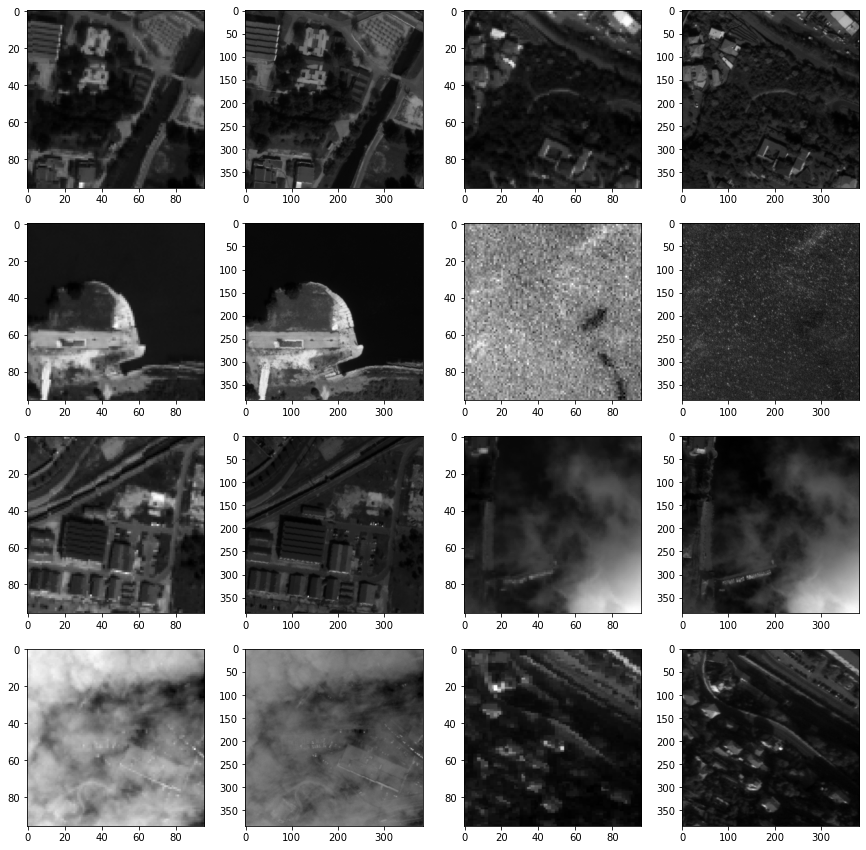

In [ ]:
def show_batch(image_batch):
    ms = image_batch[0].numpy()
    pan = image_batch[1].numpy()
    print('ms batch shape', ms.shape)
    print('pan batch shape', pan.shape)

    plt.figure(figsize=(15,15))
    for i in range(8):
        i = i * 2
        ax_ms = plt.subplot(4,4,i+1, label = 'ms')
        
        ms_image = ms[i,:,:,2] # Just showing channel 2 as grayscale
        pan_image = pan[i,:,:,0]

        #plt.imshow(ms_image)
        ax_ms.imshow(ms_image, cmap = 'gray')
        
        ax_pan = plt.subplot(4,4,i+2, label = 'pan')

        ax_pan.imshow(pan_image, cmap = 'gray')
        
show_batch(next(iter(ds_train)))